In [1]:
import time
import torch
from torch.utils.data import DataLoader, Dataset
import PIL
import os

from torchvision import transforms as transforms
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
import pickle
import torch.nn.functional as F
import seaborn as sns
import sys
sys.path.append('../')
from utils import MHCoverDataset, get_dataloader
from pathlib import Path
from utils.training import TrainingInterface
from utils.plots import EvaluationPlots

In [2]:
my_train_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=45),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomPerspective(p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.RandomAutocontrast(p=0.2),
        transforms.ToTensor(),
    ]
)

my_test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.read_csv("../data/labels_without_others.csv")

### Networks

In [5]:
resnet18 = models.resnet18(pretrained=False, progress=True)
resnet18 = TrainingInterface(model=resnet18, name="resnet18")

In [6]:
n_epochs = 50
learning_rate = 0.005

In [7]:
model = resnet18.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Typ predicion

In [40]:
with open('../utils/dataset/label_translate_t.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [41]:
trainloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df[df.set =="train"],
    fp_label_translator='../utils/dataset/label_translate_t.pkl',
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)



valloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df[df.set =="val"],
    fp_label_translator='../utils/dataset/label_translate_t.pkl',
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)


testloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df[df.set =="test"],
    fp_label_translator='../utils/dataset/label_translate_t.pkl',
    transformations=my_test_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=False
)

### Train

In [42]:
resnet18.train(criterion = criterion, optimizer = optimizer, n_epochs = n_epochs, dataloader_train = trainloader ,dataloader_val= valloader)

  0%|          | 0/2650 [00:00<?, ?it/s]

Epoch 1/50: [Train-Loss = 21.804] || [Validation-Loss = 1.297]
Epoch 2/50: [Train-Loss = 11.995] || [Validation-Loss = 1.276]
Epoch 3/50: [Train-Loss = 9.097] || [Validation-Loss = 1.205]
Epoch 4/50: [Train-Loss = 9.863] || [Validation-Loss = 1.071]
Epoch 5/50: [Train-Loss = 8.631] || [Validation-Loss = 1.076]
Epoch 6/50: [Train-Loss = 7.924] || [Validation-Loss = 0.822]
Epoch 7/50: [Train-Loss = 7.269] || [Validation-Loss = 1.669]
Epoch 8/50: [Train-Loss = 7.058] || [Validation-Loss = 0.946]
Epoch 9/50: [Train-Loss = 7.36] || [Validation-Loss = 0.925]
Epoch 10/50: [Train-Loss = 8.07] || [Validation-Loss = 1.012]
Epoch 11/50: [Train-Loss = 6.795] || [Validation-Loss = 1.122]
Epoch 12/50: [Train-Loss = 6.28] || [Validation-Loss = 2.348]
Epoch 13/50: [Train-Loss = 6.42] || [Validation-Loss = 1.127]
Epoch 14/50: [Train-Loss = 6.469] || [Validation-Loss = 0.828]
Epoch 15/50: [Train-Loss = 6.985] || [Validation-Loss = 1.513]
Epoch 16/50: [Train-Loss = 6.891] || [Validation-Loss = 0.739]
Epo

In [43]:
y_true, y_pred, y_prob, y_images = resnet18.predict(testloader)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

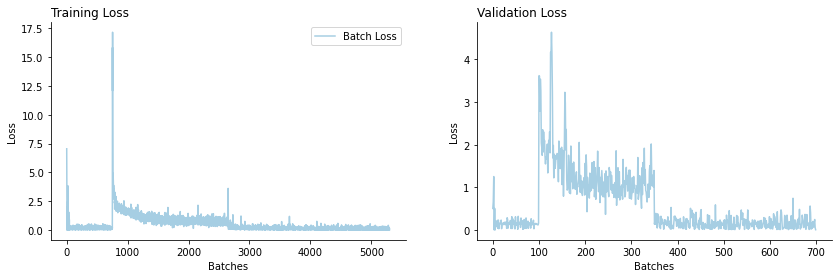

In [44]:
EvaluationPlots.plot_train_val_loss(resnet18.train_loss,resnet18.val_loss,)

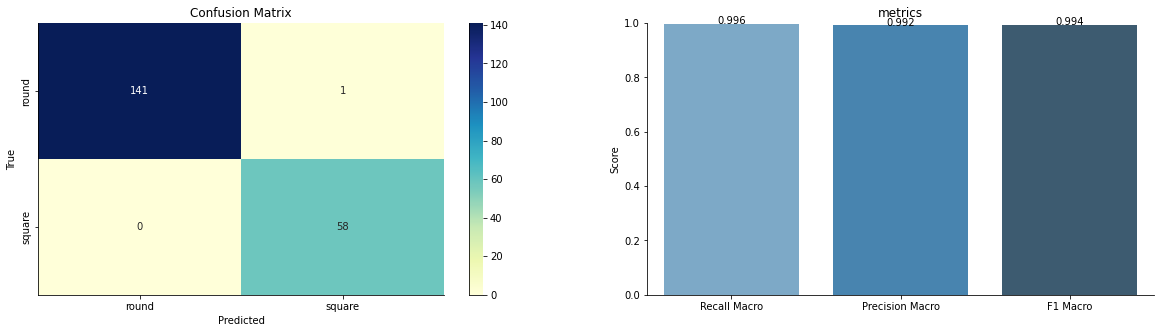

In [45]:
EvaluationPlots.metric_evaluation(y_true, y_pred,list(label_dict))

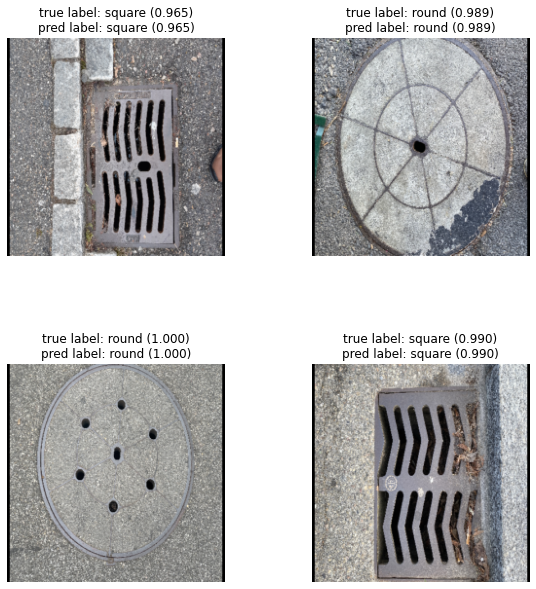

In [26]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,4, incorrect = False,label_dict=label_dict)

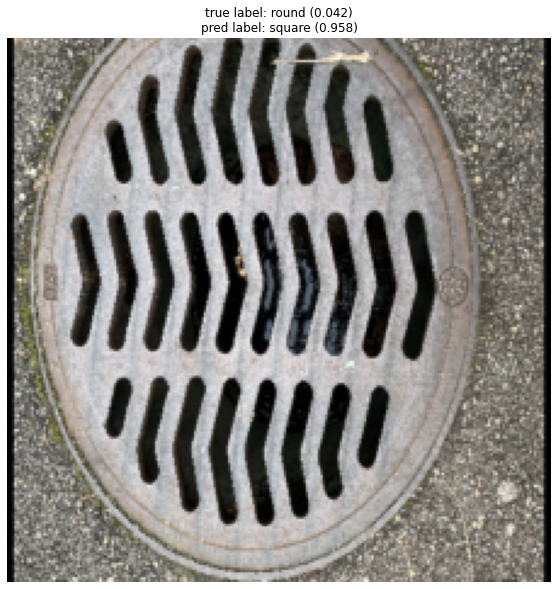

In [36]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,2, incorrect = True,label_dict=label_dict)

## Subtype prediction square

In [8]:
df_round = df[df["label"]=="round"]
df_round = df_round.drop(columns=["label"],axis=1)
df_round.rename(columns={"sublabel":"label"},inplace=True)
df_square = df[df["label"]=="square"]
df_square = df_square.drop(columns=["label"],axis=1)
df_square.rename(columns={"sublabel":"label"},inplace=True)

In [9]:
with open('../utils/dataset/label_translate_square.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [10]:
trainloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df_square[df_square.set =="train"],
    fp_label_translator='../utils/dataset/label_translate_square.pkl',
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)



valloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df_square[df_square.set =="val"],
    fp_label_translator='../utils/dataset/label_translate_square.pkl',
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)


testloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df_square[df_square.set =="test"],
    fp_label_translator='../utils/dataset/label_translate_square.pkl',
    transformations=my_test_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=False
)

### Train

In [11]:
resnet18.train(criterion = criterion, optimizer = optimizer, n_epochs = n_epochs, dataloader_train = trainloader ,dataloader_val= valloader)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/50: [Train-Loss = 23.202] || [Validation-Loss = 1.167]
Epoch 2/50: [Train-Loss = 12.901] || [Validation-Loss = 1.252]
Epoch 3/50: [Train-Loss = 7.25] || [Validation-Loss = 0.504]
Epoch 4/50: [Train-Loss = 2.798] || [Validation-Loss = 0.285]
Epoch 5/50: [Train-Loss = 2.441] || [Validation-Loss = 0.304]
Epoch 6/50: [Train-Loss = 2.443] || [Validation-Loss = 0.261]
Epoch 7/50: [Train-Loss = 2.204] || [Validation-Loss = 0.259]
Epoch 8/50: [Train-Loss = 2.168] || [Validation-Loss = 0.3]
Epoch 9/50: [Train-Loss = 2.145] || [Validation-Loss = 0.306]
Epoch 10/50: [Train-Loss = 2.188] || [Validation-Loss = 0.259]
Epoch 11/50: [Train-Loss = 2.254] || [Validation-Loss = 0.279]
Epoch 12/50: [Train-Loss = 2.211] || [Validation-Loss = 0.291]
Epoch 13/50: [Train-Loss = 2.302] || [Validation-Loss = 0.303]
Epoch 14/50: [Train-Loss = 2.262] || [Validation-Loss = 0.323]
Epoch 15/50: [Train-Loss = 2.246] || [Validation-Loss = 0.313]
Epoch 16/50: [Train-Loss = 2.17] || [Validation-Loss = 0.322]
Epo

In [13]:
y_true, y_pred, y_prob, y_images = resnet18.predict(testloader)

Calculate Predictions:   0%|          | 0/2 [00:00<?, ?it/s]

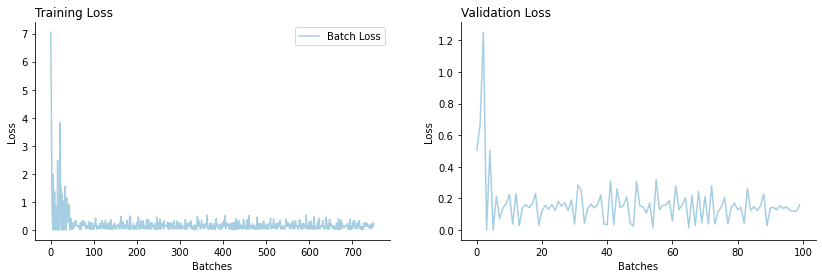

In [12]:
EvaluationPlots.plot_train_val_loss(resnet18.train_loss,resnet18.val_loss,)

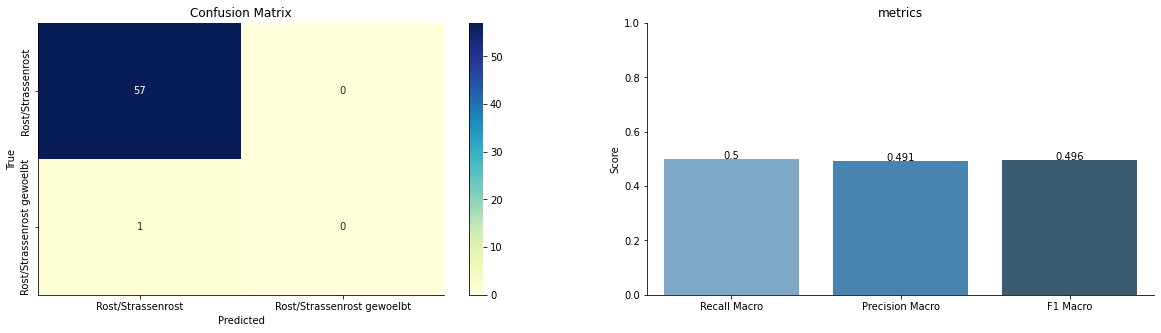

In [15]:
EvaluationPlots.metric_evaluation(y_true, y_pred,list(label_dict))

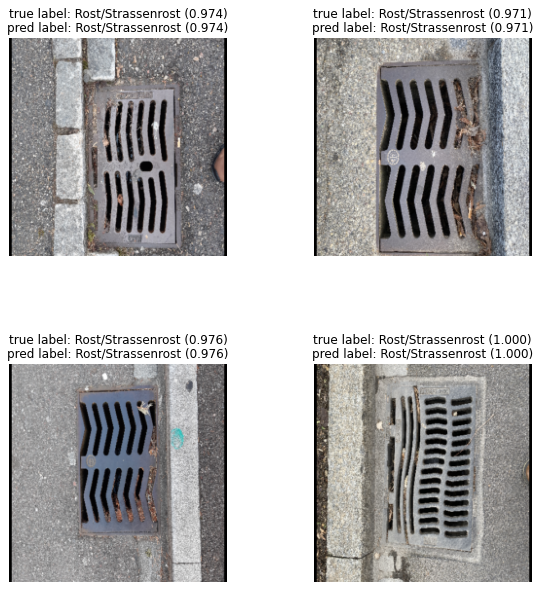

In [19]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,4, incorrect = False,label_dict=label_dict)

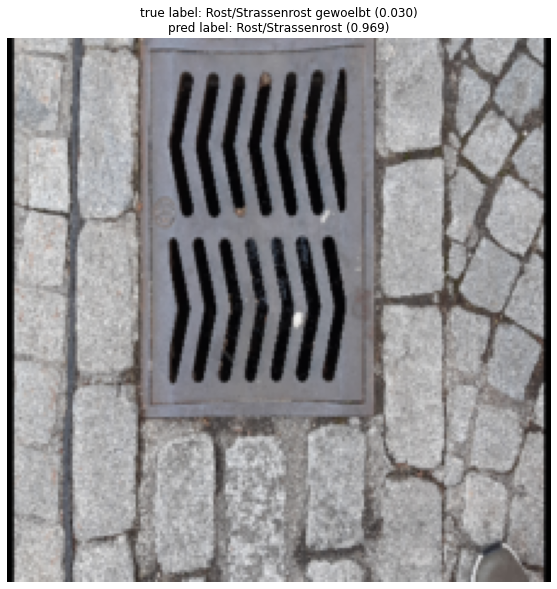

In [20]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,2, incorrect = True,label_dict=label_dict)

## Subtype prediction round

In [21]:
with open('../utils/dataset/label_translate_round.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [22]:
trainloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df_round[df_round.set =="train"],
    fp_label_translator='../utils/dataset/label_translate_round.pkl',
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)



valloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df_round[df_round.set =="val"],
    fp_label_translator='../utils/dataset/label_translate_round.pkl',
    transformations=my_train_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)


testloader = get_dataloader(
    root_dir="../data/images_transformed/",
    df=df_round[df_round.set =="test"],
    fp_label_translator='../utils/dataset/label_translate_round.pkl',
    transformations=my_test_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=False
)

### Train

In [23]:
resnet18.train(criterion = criterion, optimizer = optimizer, n_epochs = n_epochs, dataloader_train = trainloader ,dataloader_val= valloader)

  0%|          | 0/1900 [00:00<?, ?it/s]

Epoch 1/50: [Train-Loss = 200.068] || [Validation-Loss = 16.817]
Epoch 2/50: [Train-Loss = 82.682] || [Validation-Loss = 9.896]
Epoch 3/50: [Train-Loss = 73.719] || [Validation-Loss = 9.691]
Epoch 4/50: [Train-Loss = 70.923] || [Validation-Loss = 8.485]
Epoch 5/50: [Train-Loss = 65.552] || [Validation-Loss = 9.982]
Epoch 6/50: [Train-Loss = 61.658] || [Validation-Loss = 20.341]
Epoch 7/50: [Train-Loss = 58.427] || [Validation-Loss = 8.298]
Epoch 8/50: [Train-Loss = 56.294] || [Validation-Loss = 8.26]
Epoch 9/50: [Train-Loss = 54.35] || [Validation-Loss = 8.286]
Epoch 10/50: [Train-Loss = 50.56] || [Validation-Loss = 8.764]
Epoch 11/50: [Train-Loss = 47.138] || [Validation-Loss = 6.692]
Epoch 12/50: [Train-Loss = 46.581] || [Validation-Loss = 12.488]
Epoch 13/50: [Train-Loss = 42.826] || [Validation-Loss = 5.994]
Epoch 14/50: [Train-Loss = 38.532] || [Validation-Loss = 6.765]
Epoch 15/50: [Train-Loss = 38.919] || [Validation-Loss = 6.016]
Epoch 16/50: [Train-Loss = 39.215] || [Validatio

In [24]:
y_true, y_pred, y_prob, y_images = resnet18.predict(testloader)

Calculate Predictions:   0%|          | 0/5 [00:00<?, ?it/s]

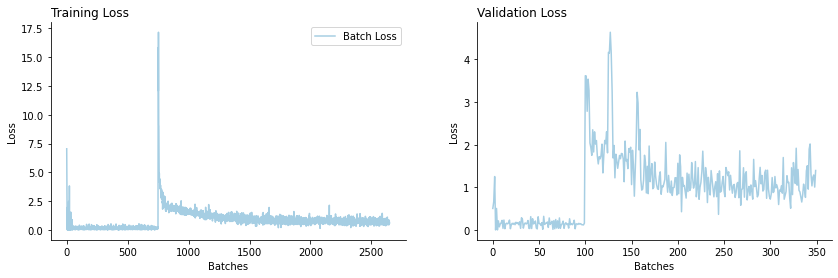

In [25]:
EvaluationPlots.plot_train_val_loss(resnet18.train_loss,resnet18.val_loss,)

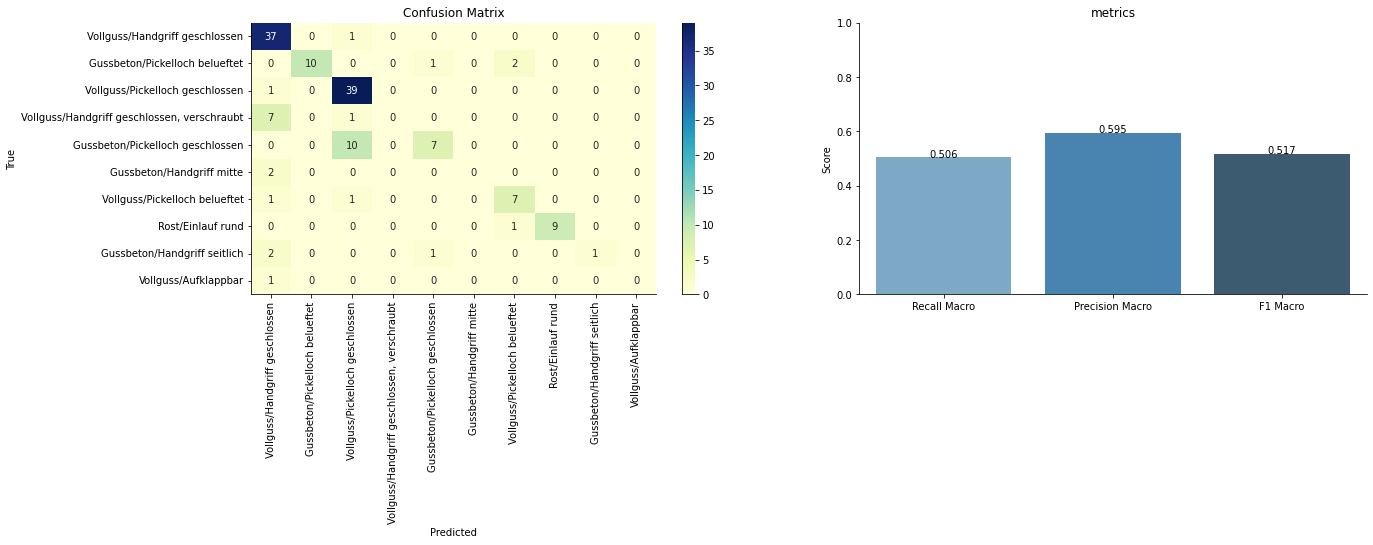

In [26]:
EvaluationPlots.metric_evaluation(y_true, y_pred,list(label_dict))

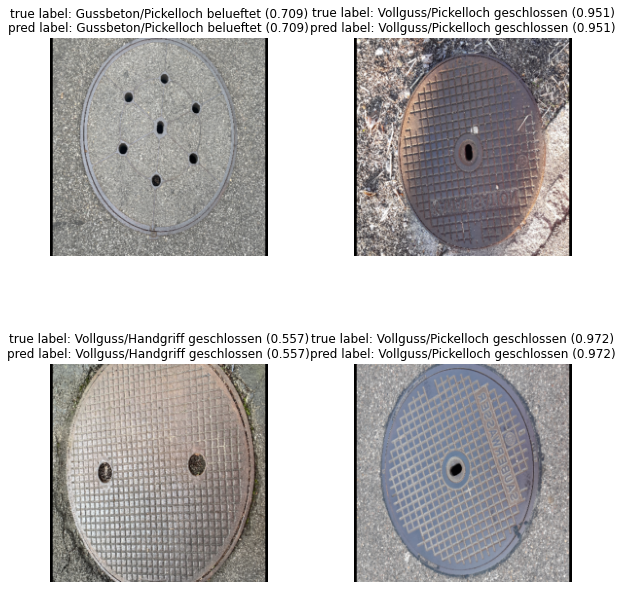

In [27]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,4, incorrect = False,label_dict=label_dict)

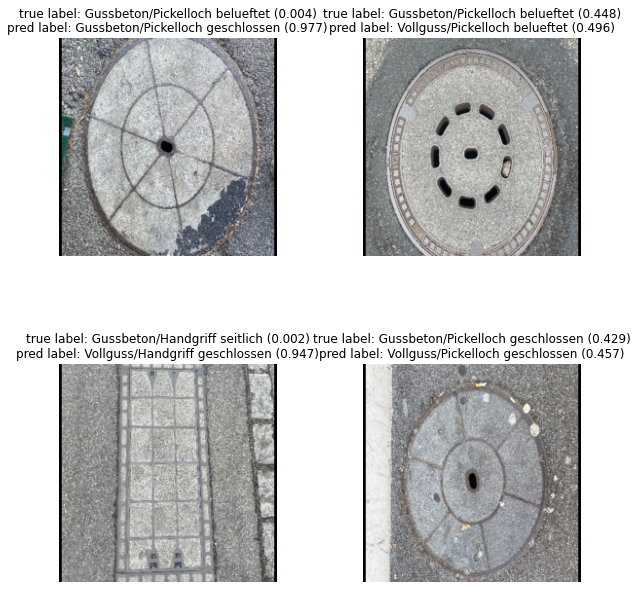

In [39]:
EvaluationPlots.plot_pred(y_true, y_pred, y_prob, y_images,4, incorrect = True,label_dict=label_dict)